In [2]:
%matplotlib inline
from scipy.io import loadmat,savemat
from scipy.linalg import *
from numpy import *
from os import listdir
from random import choice
from math import sqrt,log10,floor
import pickle,operator,pandas
import matplotlib.pyplot as plt

In [3]:
from operator import itemgetter
from collections import Counter

In [4]:
odfDim = 388

### <font color="red">Objective: Maximize the yield stress sigma(y)</font>


### <font color="green">max sigma(y)</font>
subject to :
#####  <font color="orange">   a. 0<=S11<=0.15</font>
#####  <font color="teal">  b. 0<=S22<= 0.1</font>
#####  <font color="orange">   c. 0<=C11<=125</font>
#####  <font color="teal">  d. C12>=75</font>

In [1]:
def loadDat(File,path='nonLinearData'):
    return loadmat(path+'/'+File)

def posOdf(odf):
    return nonzero(odf)[0].tolist()

def FiveSig(x):
    return float("{0:.5f}".format(x))

def getSum(odf):
    Sum = 0
    for i in range(50):
        Sum += volumefraction[i]*odf[i]
    return Sum

def checkSum(odf):
    Sum = FiveSig(getSum(odf))
    if Sum !=1.0:
        return False
    else:
        return True

def Plot(x,y,labelX="",labelY="",title=""):
    plt.plot(x,y)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def roundList(odf):
    odfAdjusted = []
    for elem in odf:
        odfAdjusted += [round(elem,6)]
    return array(odfAdjusted)
    

In [8]:
def getMaxOptBoundsFromOdf(File,path='nonLinearData'):
    Data = loadDat(File,path)['Data']
    maxOpt = 0
    maxOdf = []
    maxOdfNz = 0
    C11,C12,S11,S22 = 0,0,0,0
    
    for elem in Data:
        odf = elem[:odfDim]
        opt = elem[odfDim+4]
        if opt>maxOpt:
            maxOpt = opt
            maxOdf = roundList(odf)
            C11,C12 = elem[odfDim], elem[odfDim+1]
            S11,S22 = elem[odfDim+2], elem[odfDim+3]
            maxOdfNz = posOdf(maxOdf)
            
    print 'The optimal value is',maxOpt,'is a',str(len(maxOdfNz)),'crystal solution'
    print 'The Non zero dimensions are',
    for i in range(len(maxOdfNz)):
        print maxOdfNz[i],
    print'(Pinar max is 423.605 - 2 crystal solution 335,386 )'
    print
    print 'The C11 and C12 are',C11,'(0<=C11<=125) and',C12,'(C12>=75)'
    print 'The S11 and S22 are',S11,'(0<=S11<=0.15) and',S22,'(0<=S22<= 0.1)'
    #return roundList(maxOdf)

In [30]:
def loadNumpy(name,path='numpyData'):
    fullPath = path+'/'+name+'.npy'
    return load(fullPath)
    

def saveNumpy(obj, name, path='numpyData'):
    fullPath = path+'/'+name
    save(fullPath, obj)
    print name,'saved successfully in',path

In [23]:
data = []
Folder = 'nonLinearData'
Filename = []
for File in listdir(Folder):

    Filename += [File]
    data += [loadmat(Folder+'/'+File)]

In [6]:
volumefraction = loadmat('linprog_yield_node')['propmat'][0]

In [24]:
DIM = 388
opts = []
odfs = []
c11 = []
c12 = []
s11 = []
s22 = []

maxOdf = [[0]*DIM]*len(data)#, maxOdf]#, maxOdf]#, maxOdf]
maxOpt = [0]*len(data)#4

maxC11= [0]*len(data)
maxC12 = [0]*len(data)
maxS11= [0]*len(data)
maxS22 = [0]*len(data)


count = 0
total = 0

for i in range(len(data)):
    for odf in data[i]['Data']:
        
        odf = odf.tolist()
        opts += [odf[DIM+4]]
        c11 += [odf[DIM]]
        c12 += [odf[DIM+1]]
        s11 += [odf[DIM+2]]
        s22 += [odf[DIM+3]]
        
        odfs += [odf[:DIM]]
        
        total += 1
        
        if checkSum(odf[:DIM]):
            count += 1

        if odf[DIM+4]>maxOpt[i]:
            maxOpt[i] = odf[DIM+4]
            maxC11[i] = odf[DIM]
            maxC12[i] = odf[DIM+1]
            maxS11[i] = odf[DIM+2]
            maxS22[i] = odf[DIM+3]
            
            maxOdf[i] = odf[:DIM]

In [25]:
combined = zip(c11,c12,s11,s22,opts,odfs)
#combined.sort(key=lambda i: int(i[1]), reverse=True)
combined.sort(key=lambda x:map(float, str(float(x[-2])).split(".")), reverse=True)
c11[:],c12[:],s11[:],s22[:],opts[:],odfs[:] = zip(*combined)

In [ ]:
saveNumpy(combined,'combinedNonLinearYield')

In [ ]:
len(combined)

In [26]:
limit1 = 0.99 *423.605
limit2 = 0.995 *423.605
limit3 = 0.998 * 423.605
limit1,limit2,limit3

(419.36895000000004, 421.48697500000003, 422.75779)

### Number of solutions in 1 % and 0.5 % margin of the best solution

In [27]:
count1,count2,count3 = 0,0,0
flag,i = True,-1
flag1,flag2 = -1,-1
while flag:
    i+=1
    if opts[i]>limit1:
        count1 += 1
        if opts[i]>limit2:
            count2 += 1
            if opts[i]>limit3:
                count3 += 1
    else:
        flag = False
    #print opts[i],posOdf(odfs[i])
print count1, count2, count3

510 85 5


In [28]:
def topDimensions(LIMIT):
    List,counts = [],[]
    count1,count2 = 0,0
    for i in range(LIMIT): 
        if opts[i]>limit1:
            count1 += 1
            if opts[i]>limit2:
                count2 += 1
        else:
            flag = False
        List += posOdf(odfs[i])
    sorted_counts = sorted( Counter(List).iteritems(), key=itemgetter(1),reverse=True)
    for i in range(len(sorted_counts)):
        counts += [sorted_counts[i][0]]
    return array(counts)

In [19]:
topDimensions(5)

array([385, 334, 337])

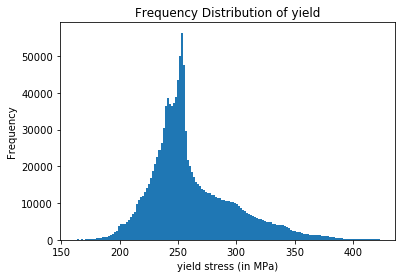

In [20]:
plt.hist(opts,bins=150)
plt.title("Frequency Distribution of yield")
plt.xlabel("yield stress (in MPa)")
plt.ylabel("Frequency")
plt.show()

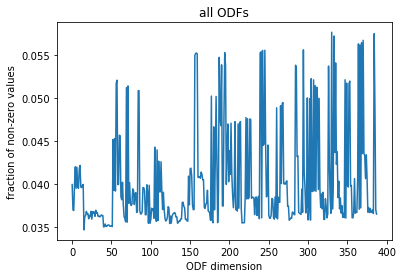

In [34]:
indices = list(range(388))
List = []
for i in range(388):
    List += [0]
    
for odf in odfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(odfs))]
Plot(indices, average,"ODF dimension","fraction of non-zero values","all ODFs")

In [24]:
indices = list(range(388))
topOdfs = odfs[:5000]
topList = []
for i in range(388):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]

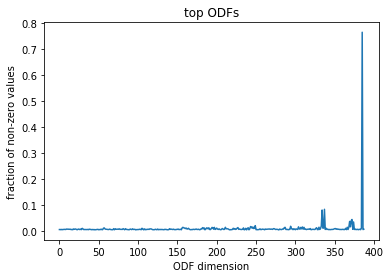

In [25]:
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","top ODFs")

### <font color="orange"> Random Forest Classification to find the top features for determining value </font> 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [26]:
edgeOdfs = topOdfs+odfs[-5000:]
edgeLabels = [1]*5000+[-1]*5000

In [27]:
edgeOdfs,edgeLabels = shuffle(edgeOdfs,edgeLabels)

In [28]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(edgeOdfs, edgeLabels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [29]:
features = clf.feature_importances_
indices = argsort(features)[::-1]
values = sorted(features, reverse=True)
for i in range(10):
    print indices[i], ':',values[i]

148 : 0.18124123408
385 : 0.0977531741073
95 : 0.0909708224227
73 : 0.0804119222892
296 : 0.0785084891468
334 : 0.0750123080792
369 : 0.0615021000041
54 : 0.0505315759466
327 : 0.0502793294217
244 : 0.0497206705783


### <font color="teal"> Random Forest Regression to find the top features for determining value </font> 

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
edgeOdfs = odfs[:5000]+odfs[-5000:]
edgeLabels = opts[:5000]+opts[-5000:]

edgeOdfs,edgeLabels = shuffle(edgeOdfs,edgeLabels)

In [32]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(edgeOdfs, edgeLabels)
features = clf.feature_importances_
indices = argsort(features)[::-1]
values = sorted(features, reverse=True)

In [33]:
for i in range(3):
    print indices[i], ':',values[i]

385 : 0.878302097373
337 : 0.0732974924785
334 : 0.0484004101486


### <font color="green"> Finding maximum values from mat files </font>

#### Small Partition 4

In [103]:
getMaxOptBoundsFromOdf('nonLinear_greedyGenerator_1000.mat')

The optimal value is 376.464694974 is a 27 crystal solution
The Non zero dimensions are 23 37 48 61 69 81 99 100 161 173 174 182 195 197 221 226 232 300 304 328 339 359 364 366 370 372 374 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 105.312899165 (0<=C11<=125) and 88.5938218924 (C12>=75)
The S11 and S22 are 0.0551561980655 (0<=S11<=0.15) and 0.0903110194981 (0<=S22<= 0.1)


In [96]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition4_200000.mat')

The optimal value is 411.641725012 is a 4 crystal solution
The Non zero dimensions are 188 191 269 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 110.383052356 (0<=C11<=125) and 86.265472799 (C12>=75)
The S11 and S22 are 0.032332008155 (0<=S11<=0.15) and 0.0989561634043 (0<=S22<= 0.1)


In [229]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition4_1000000.mat')

The optimal value is 419.270977284 is a 4 crystal solution
The Non zero dimensions are 37 339 380 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 114.162924976 (0<=C11<=125) and 83.270712773 (C12>=75)
The S11 and S22 are 0.0273748063276 (0<=S11<=0.15) and 0.093734279849 (0<=S22<= 0.1)


In [228]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition4_400000.mat')

The optimal value is 418.528410078 is a 4 crystal solution
The Non zero dimensions are 65 157 374 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 113.486842091 (0<=C11<=125) and 83.8431981719 (C12>=75)
The S11 and S22 are 0.0277688798227 (0<=S11<=0.15) and 0.0915305056831 (0<=S22<= 0.1)


#### Small Partition 3

In [212]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition3_1000000.mat')

The optimal value is 422.57334426 is a 3 crystal solution
The Non zero dimensions are 334 337 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 118.407557807 (0<=C11<=125) and 81.3650945743 (C12>=75)
The S11 and S22 are 0.0213100401949 (0<=S11<=0.15) and 0.098129846692 (0<=S22<= 0.1)


In [231]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition3_1200000.mat')

The optimal value is 420.489956331 is a 3 crystal solution
The Non zero dimensions are 151 334 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 116.803441741 (0<=C11<=125) and 82.2017090135 (C12>=75)
The S11 and S22 are 0.0230247225829 (0<=S11<=0.15) and 0.0973266527005 (0<=S22<= 0.1)


In [97]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition3_200000.mat')

The optimal value is 420.216132216 is a 3 crystal solution
The Non zero dimensions are 196 317 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 114.324658144 (0<=C11<=125) and 83.3399674663 (C12>=75)
The S11 and S22 are 0.0265787688937 (0<=S11<=0.15) and 0.0921843590543 (0<=S22<= 0.1)


In [99]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition3_300000.mat')

The optimal value is 420.585178715 is a 3 crystal solution
The Non zero dimensions are 372 381 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 114.224584385 (0<=C11<=125) and 83.2916660995 (C12>=75)
The S11 and S22 are 0.0269939856339 (0<=S11<=0.15) and 0.0920385432885 (0<=S22<= 0.1)


#### Small Partition 2

In [213]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition2_1000000.mat')

The optimal value is 422.827612418 is a 2 crystal solution
The Non zero dimensions are 337 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 119.777237741 (0<=C11<=125) and 80.7214189367 (C12>=75)
The S11 and S22 are 0.0200494987775 (0<=S11<=0.15) and 0.0999533571782 (0<=S22<= 0.1)


In [230]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition2_1100000.mat')

The optimal value is 422.768861134 is a 2 crystal solution
The Non zero dimensions are 334 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 119.443973543 (0<=C11<=125) and 80.8789468401 (C12>=75)
The S11 and S22 are 0.0203407599839 (0<=S11<=0.15) and 0.0995320161125 (0<=S22<= 0.1)


In [98]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition2_300000.mat')

The optimal value is 422.594729181 is a 2 crystal solution
The Non zero dimensions are 334 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 118.526820808 (0<=C11<=125) and 81.3091269034 (C12>=75)
The S11 and S22 are 0.0212040239376 (0<=S11<=0.15) and 0.0982832107578 (0<=S22<= 0.1)


In [64]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition2_200000.mat')

The optimal value is 421.552039446 is a 2 crystal solution
The Non zero dimensions are 337 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 114.638226054 (0<=C11<=125) and 83.0427910029 (C12>=75)
The S11 and S22 are 0.0263731870194 (0<=S11<=0.15) and 0.0908054532208 (0<=S22<= 0.1)


#### Small Partition 5

In [65]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition5_200000.mat')

The optimal value is 416.835675011 is a 5 crystal solution
The Non zero dimensions are 200 337 365 377 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 113.709185827 (0<=C11<=125) and 83.8966541273 (C12>=75)
The S11 and S22 are 0.0272400857296 (0<=S11<=0.15) and 0.0983929795265 (0<=S22<= 0.1)


#### Small Partition 6

In [66]:
getMaxOptBoundsFromOdf('nonLinear_SmallPartition6_200000.mat')

The optimal value is 401.407604389 is a 6 crystal solution
The Non zero dimensions are 16 242 244 369 371 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 108.951064149 (0<=C11<=125) and 86.8818500424 (C12>=75)
The S11 and S22 are 0.0359730956811 (0<=S11<=0.15) and 0.0946575725334 (0<=S22<= 0.1)


#### First 5 Generator

In [226]:
getMaxOptBoundsFromOdf('nonLinear_first5Generator_100000.mat')

The optimal value is 392.257559266 is a 48 crystal solution
The Non zero dimensions are 10 11 23 28 63 71 80 86 88 91 94 100 110 120 125 131 142 143 152 167 172 186 195 205 209 215 220 229 234 236 238 260 272 290 300 307 309 312 327 338 345 352 358 359 369 370 384 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 106.280940352 (0<=C11<=125) and 88.2569851472 (C12>=75)
The S11 and S22 are 0.0463601070209 (0<=S11<=0.15) and 0.096790578473 (0<=S22<= 0.1)


In [102]:
odf = getMaxOptBoundsFromOdf('nonLinear_first5Generator_50000.mat')

The optimal value is 367.178830497 is a 41 crystal solution
The Non zero dimensions are 2 34 36 41 50 63 71 74 109 111 112 119 140 152 160 169 181 183 186 204 219 247 251 264 279 280 283 292 295 299 304 308 309 334 335 336 338 345 354 376 377 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 105.004062086 (0<=C11<=125) and 89.1777839697 (C12>=75)
The S11 and S22 are 0.0528106326342 (0<=S11<=0.15) and 0.0973094668717 (0<=S22<= 0.1)


#### First 3 Generator

In [101]:
odf = getMaxOptBoundsFromOdf('nonLinear_first3Generator_50000.mat')

The optimal value is 409.629354777 is a 24 crystal solution
The Non zero dimensions are 18 19 63 77 98 99 121 126 128 165 185 186 215 219 226 246 257 282 287 288 292 320 335 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 110.955021332 (0<=C11<=125) and 85.3297643234 (C12>=75)
The S11 and S22 are 0.0325829261075 (0<=S11<=0.15) and 0.0990391882978 (0<=S22<= 0.1)


#### First 2 Generator

In [227]:
getMaxOptBoundsFromOdf('nonLinear_first2Generator_100000.mat')

The optimal value is 419.879676629 is a 22 crystal solution
The Non zero dimensions are 3 19 67 71 94 108 121 147 156 182 187 193 209 215 248 249 276 305 326 370 371 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 114.045627285 (0<=C11<=125) and 83.4419638961 (C12>=75)
The S11 and S22 are 0.027221348736 (0<=S11<=0.15) and 0.0913605652363 (0<=S22<= 0.1)


In [100]:
getMaxOptBoundsFromOdf('nonLinear_first2Generator_50000.mat')

The optimal value is 405.556178155 is a 33 crystal solution
The Non zero dimensions are 6 11 16 34 35 40 66 111 139 157 176 180 193 207 213 216 219 225 228 231 248 251 255 258 265 266 301 302 312 348 363 378 385 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 108.756840595 (0<=C11<=125) and 87.0629868783 (C12>=75)
The S11 and S22 are 0.0364210705631 (0<=S11<=0.15) and 0.098248040171 (0<=S22<= 0.1)


### Intelligent Sampling 

In [9]:
getMaxOptBoundsFromOdf('nonLinearIntel_SmallPartition2_100.mat','nonLinearIntelData')

The optimal value is 376.364924509 is a 2 crystal solution
The Non zero dimensions are 366 371 (Pinar max is 423.605 - 2 crystal solution 335,386 )

The C11 and C12 are 107.22044139 (0<=C11<=125) and 87.5593128709 (C12>=75)
The S11 and S22 are 0.0474116747121 (0<=S11<=0.15) and 0.0889897089325 (0<=S22<= 0.1)


In [11]:
odfs = loadDat('nonLinearIntel_SmallPartition2_100.mat','nonLinearIntelData')

In [21]:
posOdfList = []
for odf in odfs['odfs']:
    posOdfList += posOdf(odf)

In [22]:
list(set(posOdfList))

[384,
 2,
 388,
 263,
 265,
 271,
 195,
 152,
 156,
 160,
 162,
 304,
 309,
 312,
 314,
 193,
 323,
 331,
 333,
 336,
 338,
 339,
 213,
 90,
 349,
 223,
 364,
 366,
 367,
 370,
 371,
 245,
 254,
 383]